In [135]:
 
import urllib.request
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import re
import shifterator as sh
import matplotlib.pyplot as plt
import seaborn as sns

labMTdata = pd.read_csv('labMT.csv')
filteredLabMTdata = labMTdata[ (labMTdata['Happiness Score'] <= 3) | (labMTdata['Happiness Score'] >= 7) ]
# score_lookup = dict(zip(filteredLabMTdata['Word'], filteredLabMTdata['Happiness Score']))

def get_labMT_score_lookup(window_size=0):
    filteredLabMTdata = labMTdata[ (labMTdata['Happiness Score'] <= 5 - window_size) | (labMTdata['Happiness Score'] >= 5 + window_size) ]
    return dict(zip(filteredLabMTdata['Word'], filteredLabMTdata['Happiness Score']))

stories = {
    "pride_and_predjudice": {
        "url": "https://www.gutenberg.org/cache/epub/1342/pg1342.txt",
        },
    "frankenstein": {
        "url": "https://www.gutenberg.org/cache/epub/84/pg84.txt",
    },
    "moby_dick": {
        "url": "https://www.gutenberg.org/cache/epub/2701/pg2701.txt",
    },
    "le_miserables": {
        "url": "https://www.gutenberg.org/cache/epub/135/pg135.txt",
    }
}

def extract_content_between(content, opening_string, closing_string):
    """
    Extracts content between opening_string and closing_string.
    
    Parameters:
    - content (str): The full text content
    - opening_string (str): The string marking the start
    - closing_string (str): The string marking the end
    
    Returns:
    - str: Content from opening_string to closing_string (inclusive), or None if not found
    """
    start_idx = content.find(opening_string)
    end_idx = content.find(closing_string)
    
    if start_idx == -1 or end_idx == -1:
        return None  # Strings not found
    
    return content[start_idx:end_idx + len(closing_string)]

def get_story(story_key):
    return stories[story_key]

def get_word_frequency(words):
    """
    Generates word counts.
    
    Parameters:
    - words (list): List of words to analyze for frequency.
    
    Returns:
    - DataFrame: DataFrame with word counts.
    """
    bow = pd.Series(words).value_counts().reset_index()
    bow.columns = ['word', 'counts']        
    bow = bow.sort_values(by='counts', ascending=False).reset_index(drop=True)
    return bow

def plot_zipf_distribution(words, story):
    """
    Plots the Zipf distribution for the given transcript.
    """        
    # Rank the words by frequency
    words['rank'] = words['counts'].rank(ascending=False, method='average').astype(int)
    
    # Log-transform rank and frequency
    log_rank = np.log10(words['rank'])
    log_freq = np.log10(words['counts'])
    
    # Perform linear regression to calculate the slope
    slope, intercept, r_value, p_value, std_err = linregress(log_rank, log_freq)
    
    # Plot the Zipf distribution (log-log scale)
    plt.figure(figsize=(5, 5))
    plt.loglog(words['rank'], words['counts'], marker=".", linestyle='none', color="grey")
    
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title(f'Zipf Law - {story}')
    plt.legend()
    plt.savefig(f"plots/{story}_zipf_log_space.png")
    plt.show()

def get_percentage_of_book(words, percentage):
    """
    Returns the first 'percentage' percent of the book as a list of words.

    Parameters:
    - words (list): List of words in the book.
    - percentage (float): Percentage of the book to return.
    """
    total_words = len(words)
    cutoff_index = int(total_words * (percentage / 100))
    return words[:cutoff_index]

def get_average_happiness(word_freq_df, labMTdata):
    total_weighted_score = 0
    total_count = 0
    
    for idx, row in word_freq_df.iterrows():
        word = row['word']
        count = row['counts']
        
        if word in labMTdata['Word'].values:
            score = labMTdata.loc[labMTdata['Word'] == word, 'Happiness Score'].values[0]
            total_weighted_score += score * count  # Weight by frequency!
            total_count += count
    
    return total_weighted_score / total_count if total_count > 0 else 0

def get_word_shift_data(word_freq_df, labMTdata):
    """
    Returns a dataframe of words and their frequencies for words with happiness scores <=4 or >=6.
    """
    # create dataframe of words and their frequencies and happiness scores
    word_shift_data = {}
    for word in word_freq_df['word']:
        if word.lower() in filteredLabMTdata['Word'].values:
            if word not in word_shift_data:
                word_shift_data[word] = word_freq_df.loc[word_freq_df['word'] == word, 'counts'].values[0]
    return word_shift_data

In [136]:
moby_dick = get_story("moby_dick")
url = moby_dick["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

# remove gutenberg header and footer
moby_dick_cleaned = extract_content_between(content, 'Call me Ishmael.', 'children, only found another orphan.')
tokenizer = RegexpTokenizer(r'\w+')
split_moby_dick = tokenizer.tokenize(moby_dick_cleaned)  # Tokenize the entire content
words = [w.lower() for w in split_moby_dick]
# processed_moby_dick = preprocess_text(moby_dick_cleaned)   
# split_moby_dick = processed_moby_dick.splitlines()


In [141]:
T = 10000
score_lookup = get_labMT_score_lookup(2)
print(score_lookup)
print(words[0:10])


{'laughter': 8.5, 'happiness': 8.44, 'love': 8.42, 'happy': 8.3, 'laughed': 8.26, 'laugh': 8.22, 'laughing': 8.2, 'excellent': 8.18, 'laughs': 8.18, 'joy': 8.16, 'successful': 8.16, 'win': 8.12, 'rainbow': 8.1, 'smile': 8.1, 'won': 8.1, 'pleasure': 8.08, 'smiled': 8.08, 'rainbows': 8.06, 'winning': 8.04, 'celebration': 8.02, 'enjoyed': 8.02, 'healthy': 8.02, 'music': 8.02, 'celebrating': 8.0, 'congratulations': 8.0, 'weekend': 8.0, 'celebrate': 7.98, 'comedy': 7.98, 'jokes': 7.98, 'rich': 7.98, 'victory': 7.98, 'christmas': 7.96, 'free': 7.96, 'friendship': 7.96, 'fun': 7.96, 'holidays': 7.96, 'loved': 7.96, 'loves': 7.96, 'loving': 7.96, 'beach': 7.94, 'hahaha': 7.94, 'kissing': 7.94, 'sunshine': 7.94, 'beautiful': 7.92, 'delicious': 7.92, 'friends': 7.92, 'funny': 7.92, 'outstanding': 7.92, 'paradise': 7.92, 'sweetest': 7.92, 'vacation': 7.92, 'butterflies': 7.92, 'freedom': 7.9, 'flower': 7.88, 'great': 7.88, 'sunlight': 7.88, 'sweetheart': 7.88, 'sweetness': 7.88, 'award': 7.86, 'c

In [138]:
def get_scores(words):
    running_score = 0
    running_count = 0

    for word in words[:T]:
        if word in score_lookup:
            running_score += score_lookup[word]
            running_count += 1

    scores = [running_score / running_count if running_count > 0 else 0]
    return scores, running_score, running_count

scores, running_score, running_count = get_scores(words)

def get_time_series_scores(words, running_score, running_count):
    scores = [running_score / running_count if running_count > 0 else 0]
    x_positions = [(T - 1) / 2]

    for i in range(1, len(words) - T + 1):
        outgoing = words[i - 1]
        incoming = words[i + T - 1]
        if outgoing in score_lookup:
            running_score -= score_lookup[outgoing]
            running_count -= 1
        if incoming in score_lookup:
            running_score += score_lookup[incoming]
            running_count += 1
        scores.append(running_score / running_count if running_count > 0 else 0)
        x_positions.append(i + (T - 1) / 2)
    
    return scores, x_positions

scores, x_positions = get_time_series_scores(words, running_score, running_count)

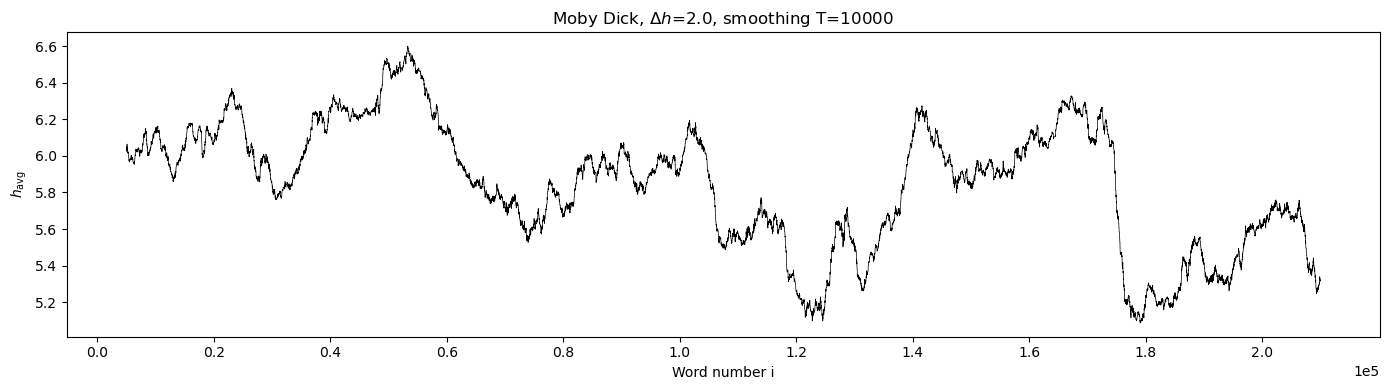

In [139]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(x_positions, scores, color='black', linewidth=0.5)

# Title and labels
ax.set_title(r'Moby Dick, $\Delta h$=2.0, smoothing T=10000')
ax.set_ylabel(r'$h_{\mathrm{avg}}$')
ax.set_xlabel('Word number i')
ax.set_xticks(np.arange(0, max(x_positions), 20000))

# Format x-axis as ×10^5
ax.ticklabel_format(style='sci', axis='x', scilimits=(5,5))

plt.tight_layout()
plt.show()

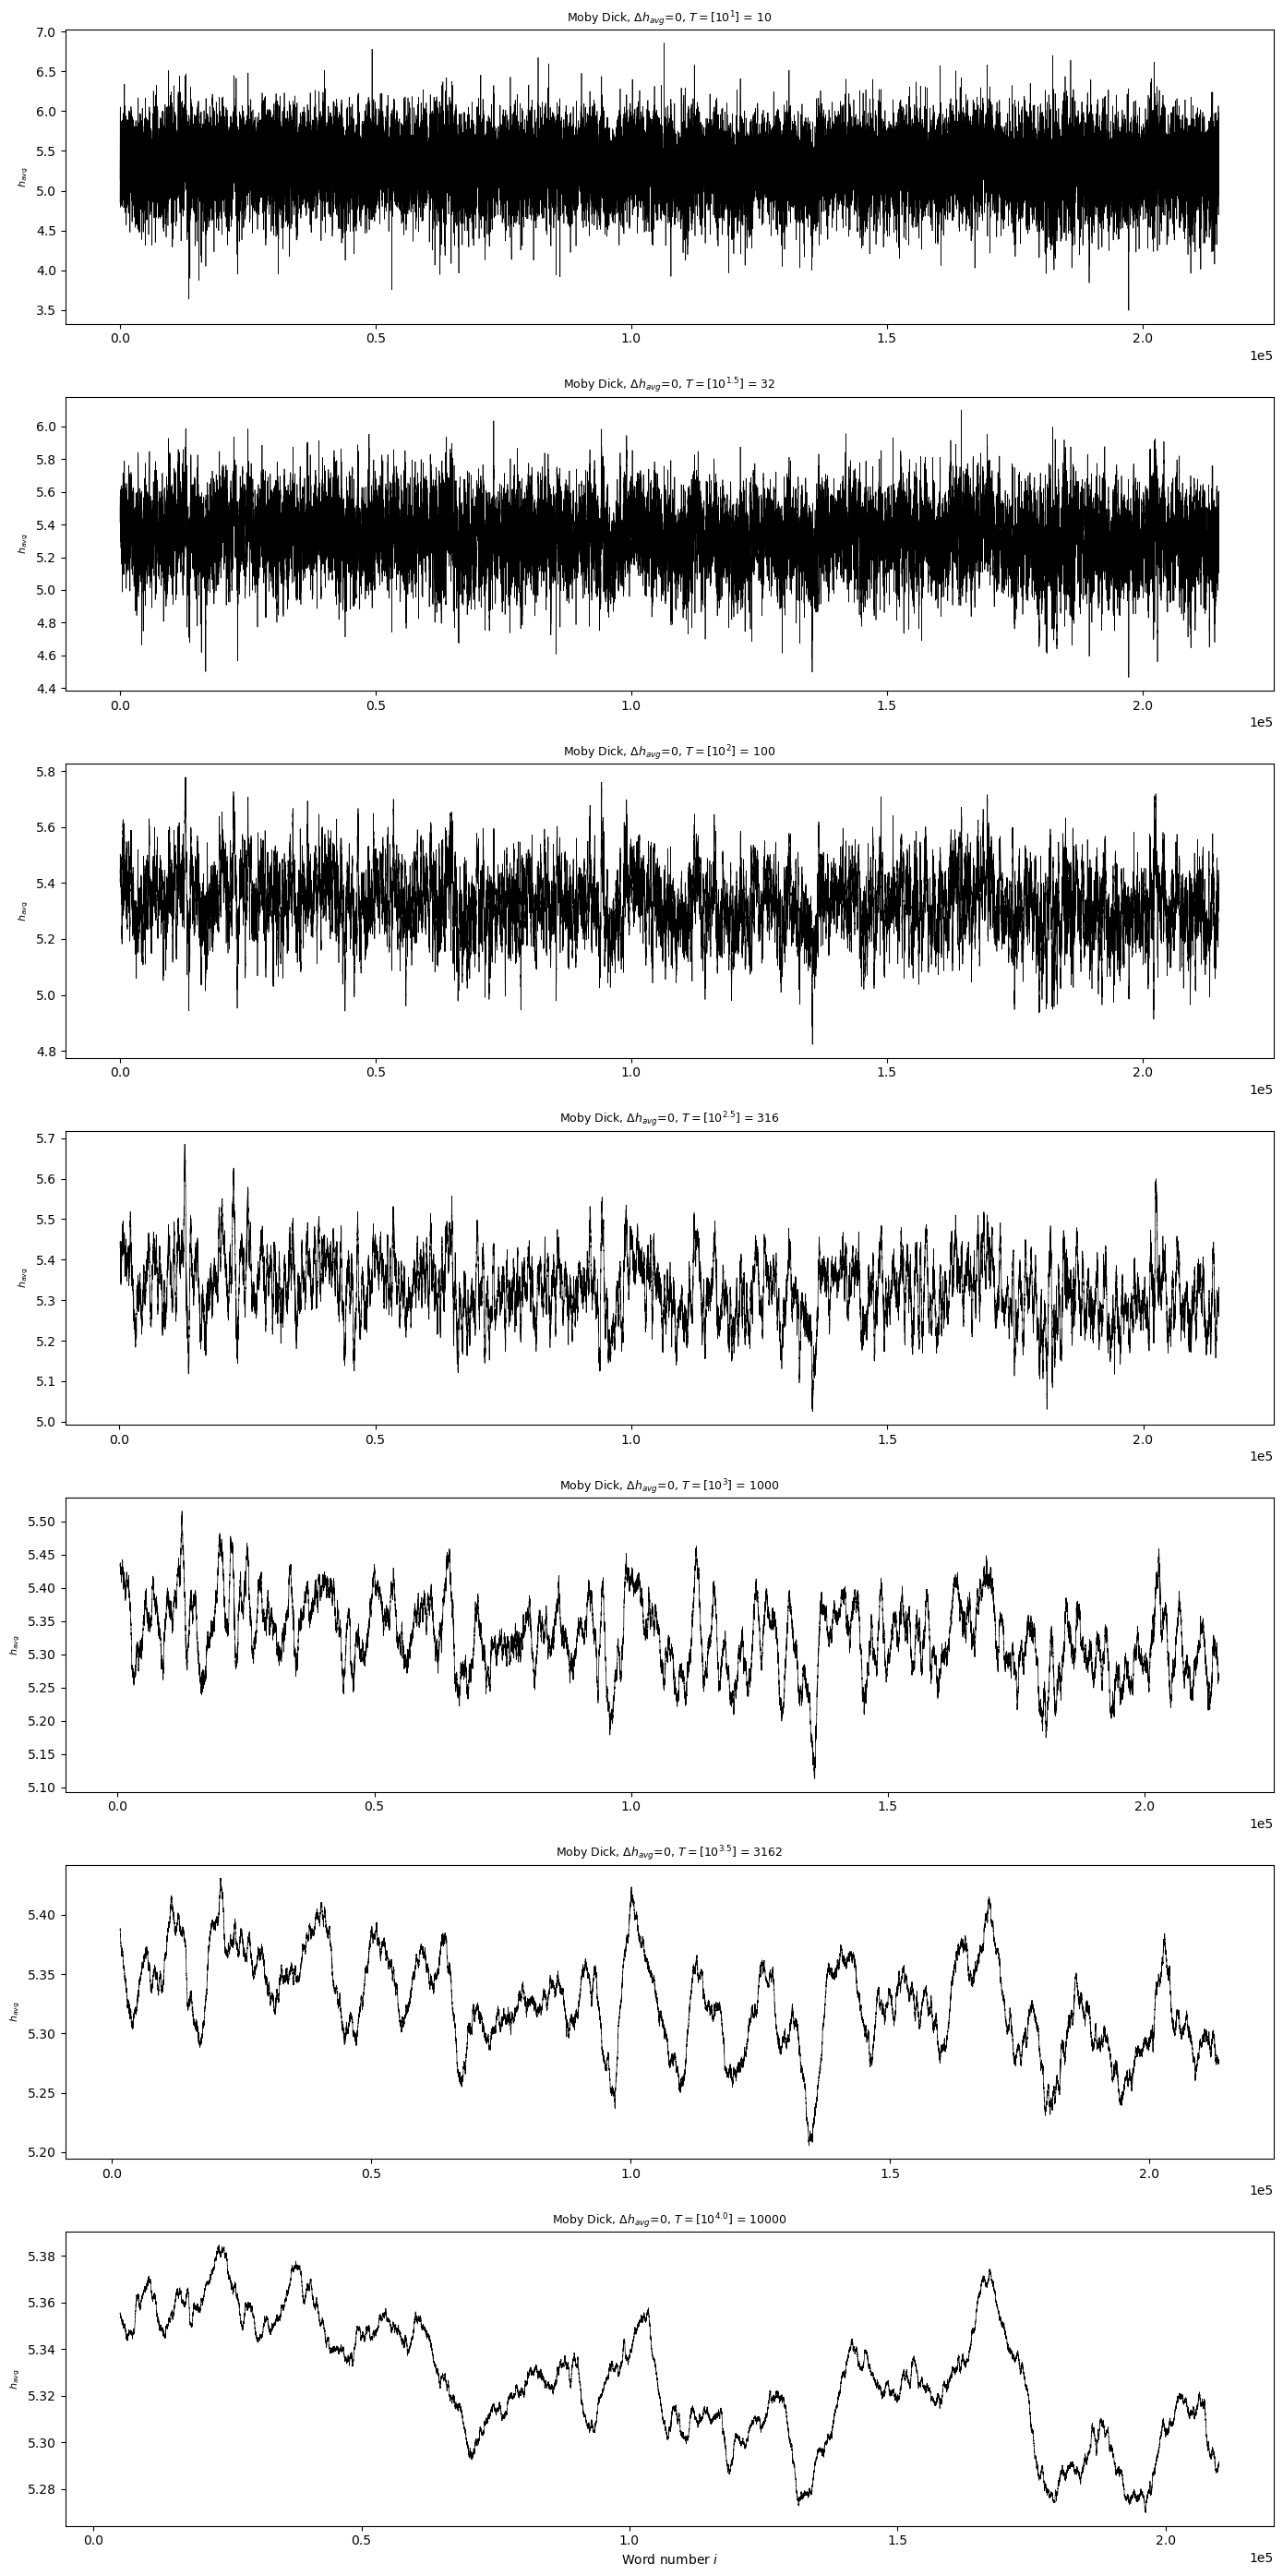

In [140]:
mu_values = [1, 1.5, 2, 2.5, 3, 3.5, 4.0]

# Full lexical lens: δh_avg = 0
score_lookup = get_labMT_score_lookup(window_size=0)

story_words = {
    "moby_dick": words,
    # "frankenstein": frankenstein_words,
    # "pride_and_predjudice": pap_words,
    # "le_miserables": lm_words,
}

for story_name, story_word_list in story_words.items():
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(14, 28), sharex=False)

    for ax, mu in zip(axes, mu_values):
        T = round(10**mu)  # update global T used by your functions

        scores, running_score, running_count = get_scores(story_word_list)
        scores, x_positions = get_time_series_scores(story_word_list, running_score, running_count)

        ax.plot(x_positions, scores, color='black', linewidth=0.5)
        ax.set_title(
            rf'{story_name.replace("_", " ").title()}, $\Delta h_{{avg}}$=0, $T = [10^{{{mu}}}]$ = {T}',
            fontsize=9
        )
        ax.set_ylabel(r'$h_{\mathrm{avg}}$', fontsize=8)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    axes[-1].set_xlabel('Word number $i$')
    plt.tight_layout()
    plt.savefig(f"plots/{story_name}_stacked_mu.png", dpi=150)
    plt.show()